<div style="font-size: 60px;padding: 200fpx;">
    
<center>
    
**PROGETTO DMML 2024**
    
<span style="font-size: 30px;padding: 200fpx;">
    
*Classification*
</span>
</center>
    
    
<span style="font-size: 18px;padding: 200fpx;">

Alessandrelli Andrea, Antonini Luca, Cofrancesco Angela
    
</span>

</div>

***
***
***

# **Indice**



<span style="font-size: 18px;">
    
<div class="alert alert-block alert-warning">
    
- [Librerie e funzioni utili](#**Librerie-e-funzioni-utili**)

- [Classification](#**Classification**)
    -  [Decision Tree](##**Decision-Tree**)
    -  [KNN](##**KNN**)
    -  [Random Forest](##**Random-Forest**)
    -  [SVM](##**SVM**)

</div>
</span>

Abbiamo deciso di dividere ogni notebook in due macrosezioni: la prima parte più descrittiva, in cui si tiene traccia attraverso grafici, immagini e parole, dei passaggi e delle strategie adoperate e dei risultati ottenuti, e una seconda parte, complementare alla prima, in cui viene presentato il codice.

***
***
***

# **Librerie e funzioni utili**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import norm
import seaborn as sns
# per mostrare tutte le colonne
from IPython.display import display

In [3]:
# per la normalizzazione e la standardizzazione dei dati
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# utile nel caso fosse necessario applicare la PCA
from sklearn.decomposition import PCA

In [ ]:
# per utilizzare una search più ottimizzata
if False:
    !pip install optuna
import optuna
from optuna.samplers import TPESampler

In [ ]:
if False:
    !pip install scikit-plot
# per ottenere le accuracy, la confusion matrix, la ROC curve e il classification report
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [6]:
# utile per la Stratified K Fold Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold

In [7]:
# per lo split tra training e test set
from sklearn.model_selection import train_test_split
# per utilizzare la random search e la grid search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [9]:
# per la KNN-classification
from sklearn.neighbors import KNeighborsClassifier
# per il Decision Tree e i relativi plot
from sklearn.tree import DecisionTreeClassifier, plot_tree
# per la classificazione con Random Forest
from sklearn.ensemble import RandomForestClassifier
# per la classificazione con SVC
from sklearn.svm import LinearSVC, SVC


# per salvare i parametri di training
from joblib import dump, load



In [10]:
import warnings

# disabilita tutti i warning
warnings.filterwarnings("ignore")

<div style="font-size: 25px;padding: 20fpx;">

**Funzioni utili**
</div>

In [11]:
# funzione che prende in INPUT una colonna di un dataframe e da in OUTPUT la percentuale di outliers presenti
def perc_outlier(x):
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1
    # lista delle colonne con outliers
    outliers = list()
    for v in x:
        if v < q1 - 1.5 * iqr or v > q3 + 1.5 * iqr:
            outliers.append(True)
        else:
            outliers.append(False)

    # restituisce la percentuale di outliers presenti nella colonna x
    return np.array(outliers).sum()/len(x)

In [12]:
# funzione che restituisce le colonne con correlazione >delta o <delta

def coor_map(df, delta):
    correlation_matrix =df.corr(numeric_only=True)

    # lista con il nome delle due colonne coinvolte e il relativo valore di correlazione
    highly_correlated_columns = list()
    for column in correlation_matrix.columns:
      high_corr = list(correlation_matrix.index[np.abs(correlation_matrix[column]) >= delta])

      high_corr.remove(column)
      for hh in high_corr:
          highly_correlated_columns.append([column, hh, correlation_matrix[column][hh]])
    # ordinamento in base al valore della correlazione
    highly_correlated_columns=sorted(highly_correlated_columns, key= lambda x:x[2], reverse=True)

# eliminazione dei doppioni poiché la coor_matrix è simmetrica
    # Lista per tenere traccia delle tuple già viste
    seen = set()
    filtered_data = []
    for item in  highly_correlated_columns:
    # Ordina la tupla dei primi due elementi in modo da standardizzare l'ordine
        sorted_pair = tuple(sorted(item[:2]))
    # Se la tupla non è già stata vista, aggiunge l'elemento ai dati filtrati e segna la tupla come vista
        if sorted_pair not in seen:
            filtered_data.append(item)
            seen.add(sorted_pair)
# restituisce un array con ogni elemento della forma ['colonna_x', 'colonna_y', correlazione_xy]
    return filtered_data

In [13]:
# tra le colonne numeriche, salviamo in cc quelle che hanno una percentuale di outliers maggiore del valore soglia
def rimoz_outliers(df, soglia):
    col_num = df.select_dtypes(exclude='bool').columns
    col_da_scartare = []
    for c in col_num:
        controll = perc_outlier(df[c])*100
        if controll > soglia:
            col_da_scartare.append(c)

    df_No_out = df[df.columns.drop(col_da_scartare)]
    return df_No_out

In [14]:
pd.options.display.max_columns = None # per visualizzare tutte le colonne

---
---
---

<div style="font-size: 20px;padding: 200fpx;">

# **Classification**

</div>

***
***

<center>
<div style="font-size: 30px;padding: 200fpx;">

## **Discussione**

</div>

</center>

<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: right;">

Per questa sezione relativa alla Classificazione, partendo dall'idea di voler allenare dei modelli per decifrare le emozioni, in un primo momento, si è proceduto a escludere dal dataframe la variabile target 'emotion', salvandola in *y_em*, per poi sfruttare il dummy encoder, procedere a convertire le restanti variabili categoriche dicotomiche in booleane (conservando una sola colonna per attributo). Successivamente si è applicata una trasformazione MinMax alle variabili numeriche.

Per ognuno dei 4 modelli allenati (Decision Tree, KNN, Random Forest e SVM), tramite un apposita funzione si è proceduto ad eliminare dai rispettivi training e test set gli attributi che presentavano una percentuale di outliers maggiore di una certa soglia, personalizzata per ogni modello. Successivamente si è proceduto, con stratificazione rispetto alla variabile target (y_em), a separare Training set da Test set.

Tramite optuna e utilizzando una Repeated Stratified K Fold CV abbiamo proceduto a settare il valore degli iperparametri che andavano a massimizzare le performance dei vari modelli in termini di accuracy.

I risultati dei vari modelli addestrati sono poi stati analizzati e interpretati utilizzando i rispettivi test set.



**RISULTATI**

Riportiamo di seguito le confusion matrix, i classification report e le curve di ROC dei tre modelli in esame.

</div>

<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: left;">

*REPORT*

come si evince dai classification report, il modello con l'accuracy migliore è il Random Forest con 0.55, seguito dall'SVM con 0.53 e il KNN con 0.52, il peggiore in termini di accuratezza è il Decision Tree con solo 0.44.

</div>

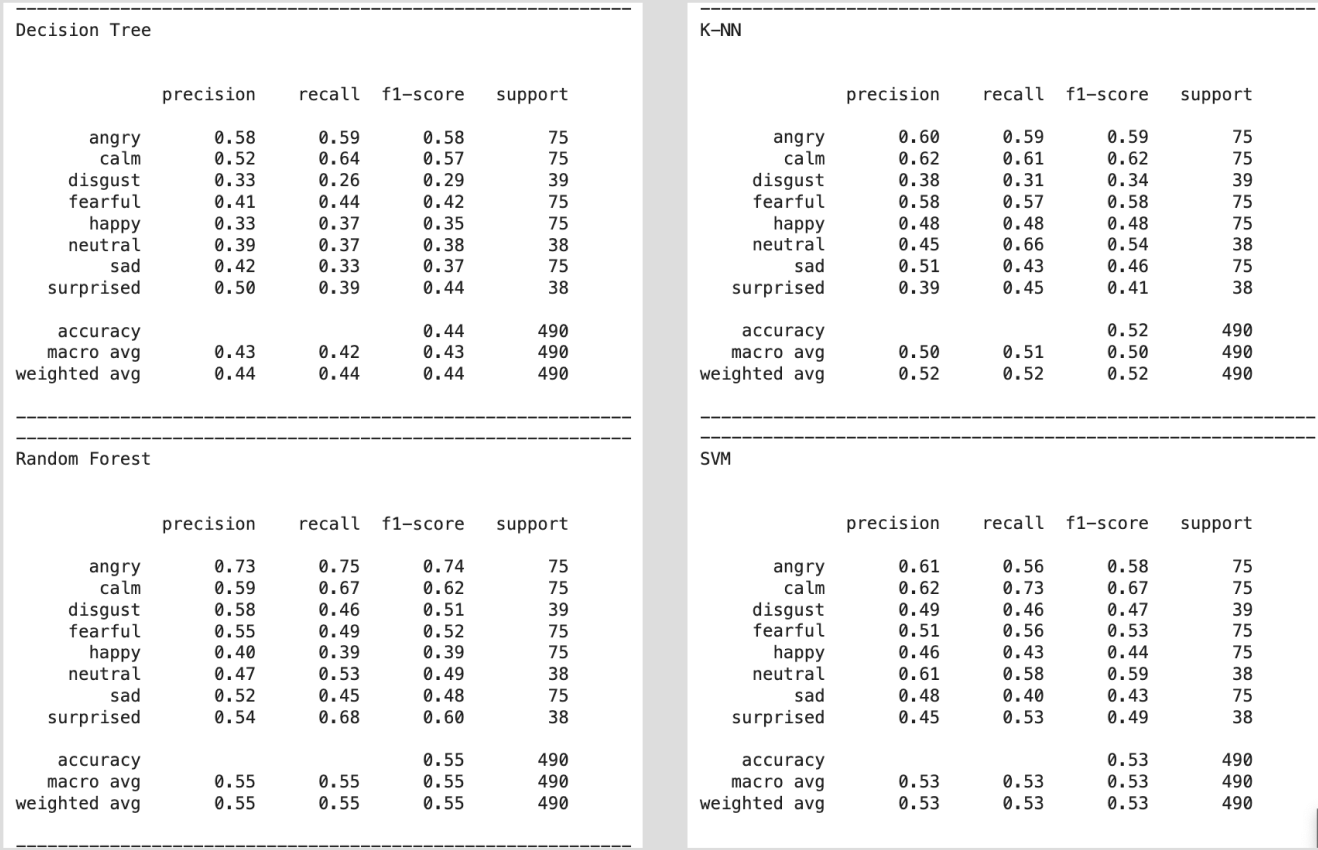

<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: left;">

*CONFUSION MATRIX*

Dalle confusion matrix si evince come in tutti i modelli le classi con le più alte percentuali di riconoscimento sono state  'angry'  e 'calm'

</div>

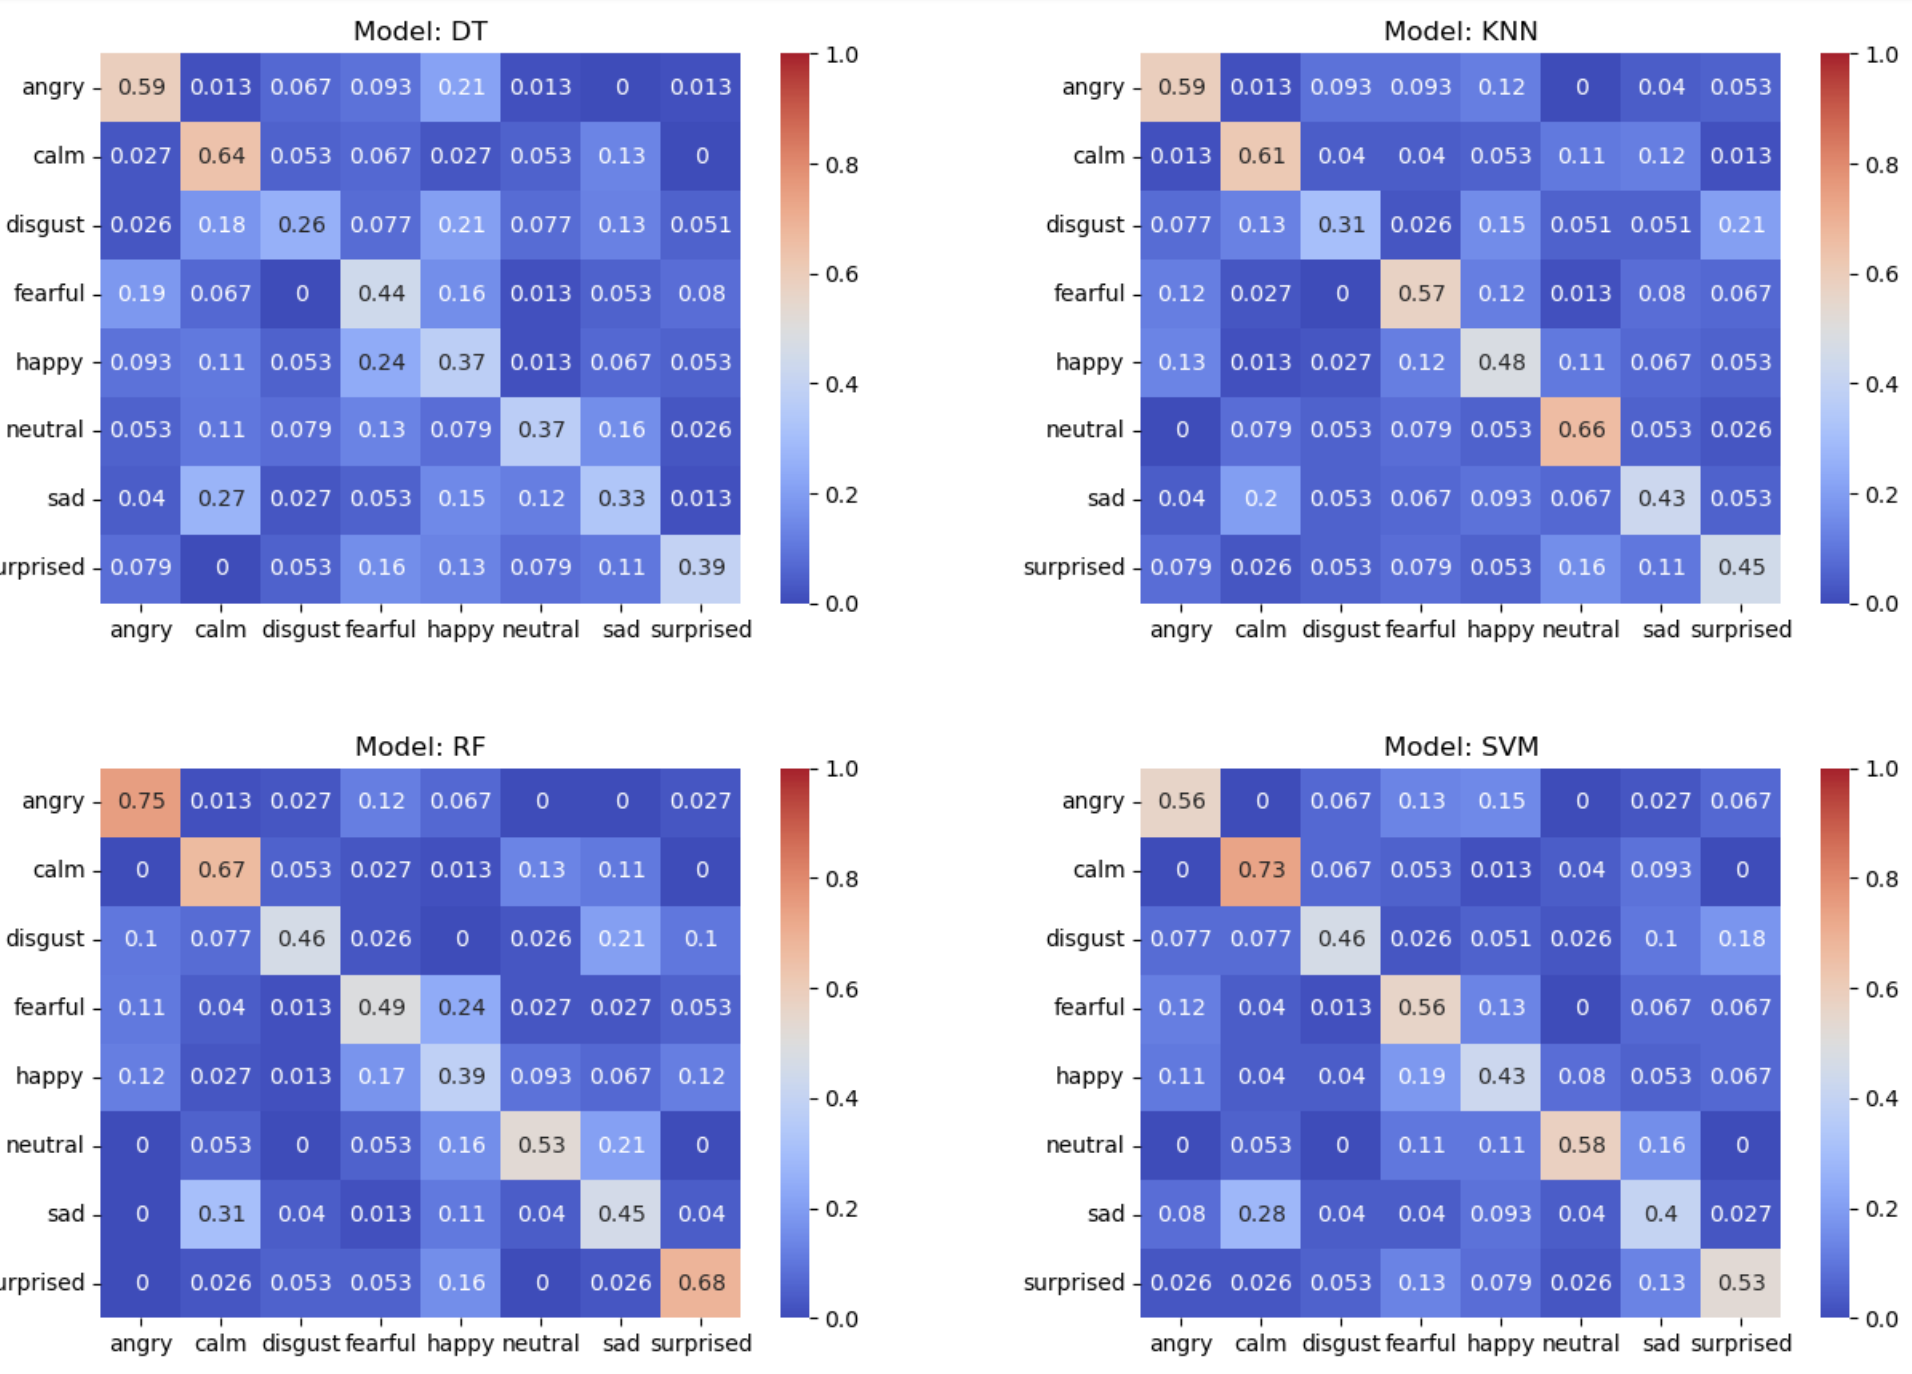






<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: left;">

*ROC curves*

Dall'analisi delle curve ROC dei vari modelli, nonostante le accuracy vicine allo 0.55, si evince la bontà delle classificazioni prodotte dal Random Forest e il SVM.

Il modello con le prestazioni meno promettenti, sia in termini di accuracy che di precision, risulta essere il Decision Tree.

</div>


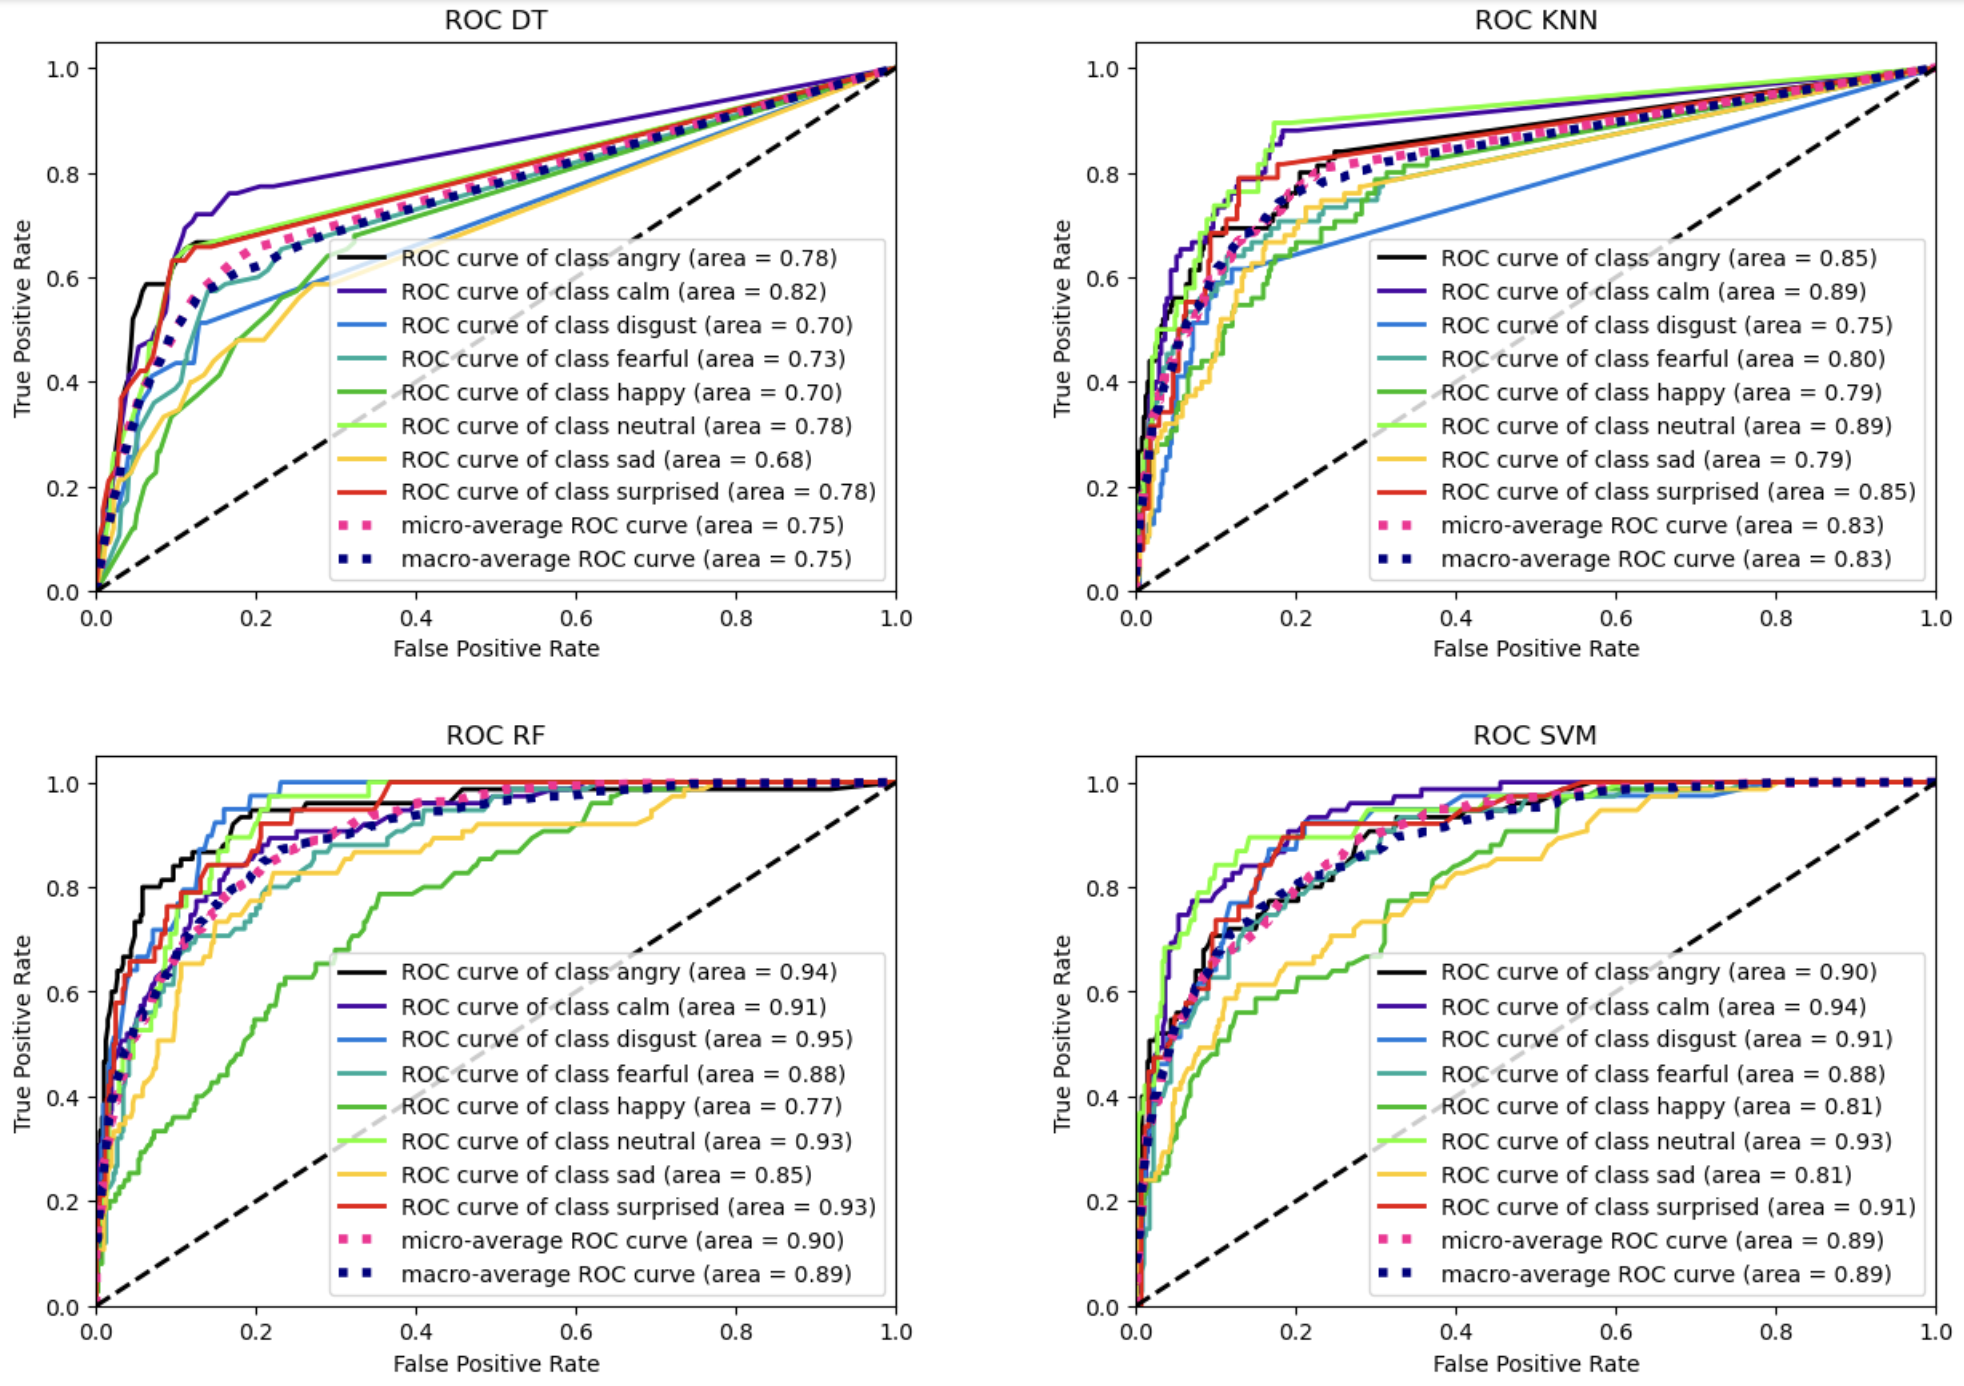

<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: left;">

Nonostante l'accuracy possa sembrare piuttosto bassa, in realtà il processo di classificazione risulta essere abbastanza promettente se consideriamo l'elevato numero di emozioni (ben 8) presenti.

</div>

***
***

## **Codice**

In [15]:
# carichiamo il file csv con il dataset già preprocessato
df = pd.read_csv('data/data_esame_trasformato.csv', sep=',', skipinitialspace=True)

# salviamo in y_em le label di ogni riga relative alle otto classi di 'emotion'
y_em = df['emotion']


In [16]:
# convertiamo in binarie le variabili categoriche con due valori, preservando solo una colonna per attributo
dummy_df_train = pd.get_dummies(df, columns=['vocal_channel', 'emotional_intensity', 'statement', 'sex', 'repetition'],drop_first=True, prefix_sep='=')

# eliminiamo la colonna relativa alla label 'emotion'
dummy_df_train.drop(columns=['emotion'], inplace = True)

In [17]:
# salviamo in df_num il datset di train relativo alle sole variabili di tipo continuo
df_num=dummy_df_train[dummy_df_train.select_dtypes(exclude='bool').columns]

# salviamo in df_cat il dataset di train relativo alle sole variabili di tipo categorico
df_cat=dummy_df_train[dummy_df_train.select_dtypes('bool').columns]

# applichiamo il MinMax Scaler alle sole colonne categorcihe
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(df_num)

# reinseriamo il dataset riscalato in df_num
df_num = pd.DataFrame(scaled_data, columns=df_num.columns)

# rimettiamo insieme le variabili continue riscalate e quelle categoriche
df_scaler=pd.concat([df_num,df_cat], axis=1)
df_scaler.head()

,length_ms,zero_crossings_sum,mfcc_mean,mfcc_max,sc_std,sc_min,sc_max,stft_std,stft_min,stft_kur,kur,skew,PCA1,PCA2,PCA3,vocal_channel=speech,emotional_intensity=strong,statement=Kids are talking by the door,sex=M,repetition=2nd
0,0.233052,0.482620,0.364634,0.295213,0.684293,0.0,0.599230,0.750780,0.0,0.280433,0.373103,0.632712,0.438709,0.496892,0.195952,True,False,False,False,True
1,0.281641,0.361159,0.505299,0.511665,0.849748,0.0,0.442238,0.829370,0.0,0.185445,0.605972,0.637285,0.487586,0.436403,0.167495,True,False,False,False,False
2,0.504801,0.550566,0.468918,0.254710,0.685337,0.0,0.442998,0.828865,0.0,0.265390,0.196479,0.639811,0.515831,0.535717,0.199960,False,True,False,False,True
3,0.203957,0.271154,0.273763,0.414398,0.852430,0.0,0.447119,0.866146,0.0,0.148641,0.473120,0.547498,0.282203,0.556096,0.184231,True,False,True,False,False
4,0.427117,0.409563,0.438075,0.226628,0.713171,0.0,0.444813,0.821494,0.0,0.195683,0.307612,0.666810,0.531230,0.479020,0.249335,False,True,False,False,True


Il nostro dataset per la classificazione delle 'emotion' è formato da un totale di 15 colonne di tipo float64 e 5 colonne di tipo categorico convertite in bool

***

### **Decision Tree**

In [18]:
# utilizzando la funzione *rimoz_outliers* dal dataset 'dummy_df_train' eliminiamo tutte le colonne con una percentuale di outliers inferiore a soglia
soglia = 3
df_DT = rimoz_outliers(dummy_df_train, soglia)
X = df_DT.values

# divido il dataset originale con stratificazione sulle y_em
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X, y_em, test_size=0.2, stratify=y_em, random_state=3)
X_train_DT.shape, X_test_DT.shape

((1956, 17), (490, 17))

In [19]:
# abbiamo usato optuna per andare a settare gli iperparametri migliori per il nostro training (https://optuna.org/)
def objective_DT(trial):
    # Definizione degli intervalli dei parametri entro cui cercare
    params = {
         "min_samples_split": trial.suggest_float("min_samples_split", 0.0,1.0),
         "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
         "max_depth": trial.suggest_int("max_depth", 2, 200),
         "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
    }

    # passaggio dei parametri al Decision Tree
    dt = DecisionTreeClassifier(**params)
    # Repeated Stratified KFold con 5 split e n_repeats ripetizioni
    skf= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(dt, X_train_DT, y_train_DT, cv=skf, scoring="accuracy")
    score = np.mean(scores)

    return score

In [20]:
# mettere a True se si riallena il modello, lasciare a False se si vuole caricare il modello già allenato
controllo = False

if controllo:
    # usiamo  il campionatore TPE per effettuare una ricerca efficiente nello spazio degli iperparametri
    study = optuna.create_study(sampler=TPESampler(), direction="maximize")
    study.optimize(objective_DT, n_trials=100, n_jobs=-1, timeout=20000)

    bests=study.best_params

    # allenamento del modello con gli iperparametri ottimali trovati da optuna
    dt = DecisionTreeClassifier(**bests, random_state=0)
    dt.fit(X_train_DT, y_train_DT)

    ## Salvataggio del modello su disco
    dump(dt, 'trained_model/class_tree_model.joblib')

else:
    ## Caricamento del modello
    dt = load('trained_model/class_tree_model.joblib')


***
<div style="background-color: #ffcccc; padding: 10px;">

**I migliori parametri del training sono:**

{'min_samples_split': 0.003005277271313278, 'max_features': None, 'min_samples_leaf': 5, 'max_depth': 63, 'criterion': 'entropy'}

</div>

***

In [21]:
# calcolo dell'accuracy
y_pred_DT = dt.predict(X_test_DT)
accuracy_score(y_test_DT, y_pred_DT)

0.4326530612244898

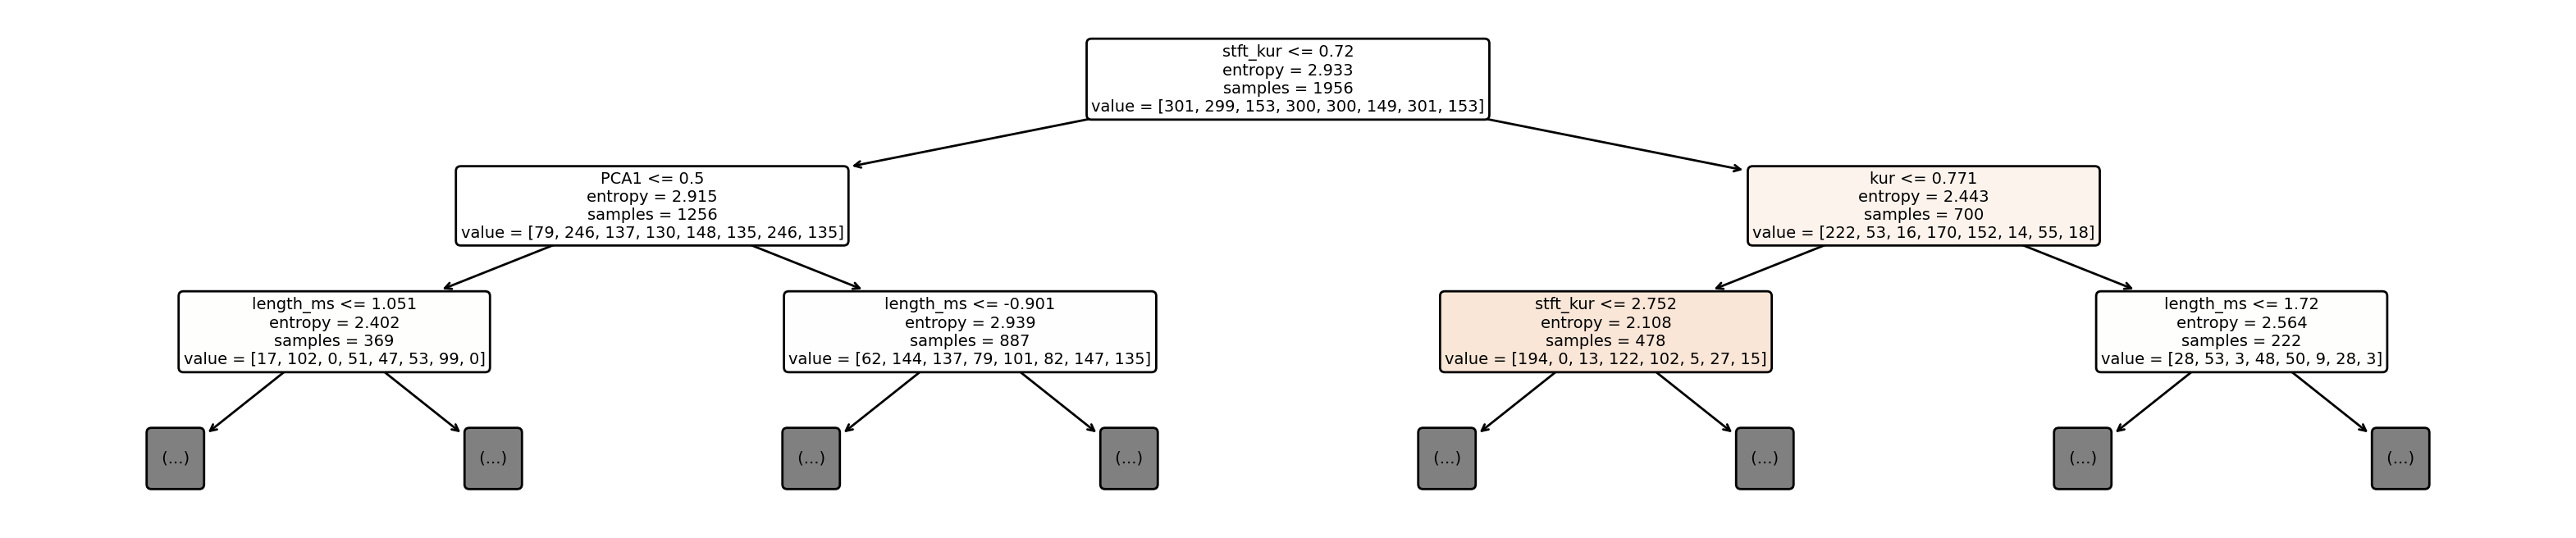

In [22]:
# per visualizzare i primi nodi dell'albero decisionale
plt.figure(figsize=(20, 4), dpi=200)
plot_tree(dt, feature_names=df_scaler.columns, filled=True, rounded=True, fontsize=7, max_depth=2)
plt.show()

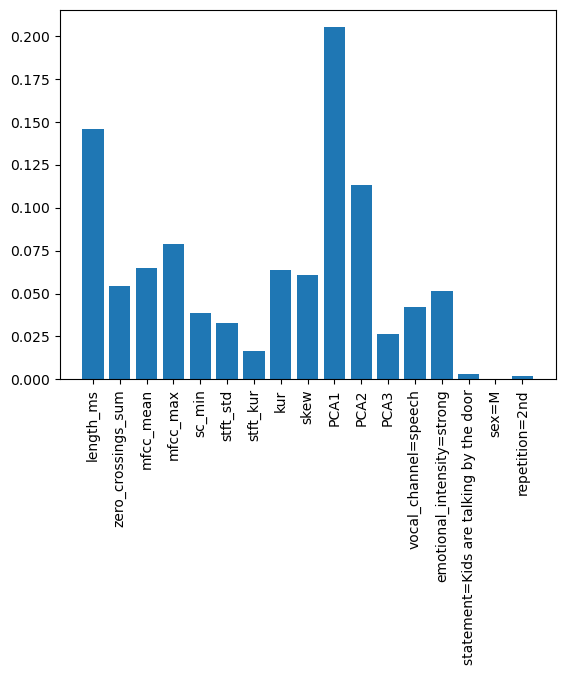

In [23]:
# visualizzazione dei parametri più significativi nel processo di classificazione
plt.bar(df_DT.columns, dt.feature_importances_)
plt.xticks(rotation=90)
plt.show()

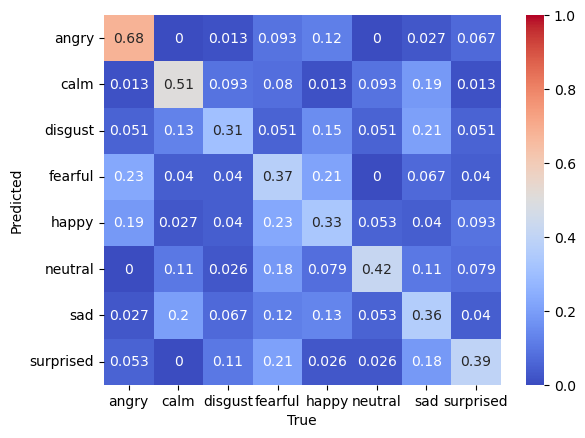

In [24]:

# codice che stampa la confusion matrix per il processo di classificazione
cf_DT = confusion_matrix(y_test_DT, y_pred_DT, normalize='true')
sns.heatmap(cf_DT, annot=True, cmap="coolwarm",  vmin=0, vmax=1, yticklabels=np.unique(y_pred_DT), xticklabels=np.unique(y_pred_DT))
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [25]:
y_test_pred_proba_DT = dt.predict_proba(X_test_DT)

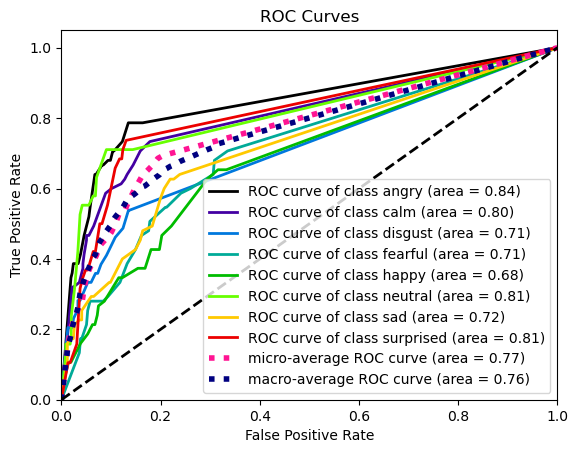

              precision    recall  f1-score   support

       angry       0.57      0.68      0.62        75
        calm       0.57      0.51      0.54        75
     disgust       0.33      0.31      0.32        39
     fearful       0.33      0.37      0.35        75
       happy       0.35      0.33      0.34        75
     neutral       0.47      0.42      0.44        38
         sad       0.39      0.36      0.37        75
   surprised       0.38      0.39      0.39        38

    accuracy                           0.43       490
   macro avg       0.42      0.42      0.42       490
weighted avg       0.43      0.43      0.43       490



In [26]:
# curva di ROC relativa al nostro classificatore dt con relative metriche
ROC_DT=plot_roc(y_test_DT,y_test_pred_proba_DT)
plt.show()
CR_DT=classification_report(y_test_DT, y_pred_DT)
print(CR_DT)

***

### **KNN**

In [27]:
# selezione delle colonne che hanno solo attributi continui e con una percentuale di outliers inferiore alla soglia
soglia = 3
df_No_out = rimoz_outliers(dummy_df_train, soglia)
X = df_No_out[df_No_out.select_dtypes(exclude='bool').columns].values

# divisione, con stratificazione lungo y_em, di training set e test set
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X, y_em, test_size=0.2, stratify=y_em, random_state=3)
X_train_KNN.shape, X_test_KNN.shape

((1956, 12), (490, 12))

In [28]:
# ricerca dei parametri ottimali con optuna
def objective_KNN(trial):

    params = {
         "n_neighbors": trial.suggest_int("n_neighbors", 2, 200),
         "weights":trial.suggest_categorical("weights", ["uniform", "distance"]),
         "metric":trial.suggest_categorical("metric", ["euclidean", "cityblock"]),
    }

    knn_classifier = KNeighborsClassifier(**params)
    skf= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=2)
    scores = cross_val_score(knn_classifier, X_train_KNN, y_train_KNN, cv=skf, scoring="balanced_accuracy")
    score = np.mean(scores)

    return score

In [29]:
# mettere a True se si riallena il modello, lasciare a False se si vuole caricare il modello già allenato
controllo = False

if controllo:
    study = optuna.create_study(sampler=TPESampler(), direction="maximize")
    study.optimize(objective_KNN, n_trials=100, n_jobs=-1, timeout=20000)

    bests=study.best_params

    # allenamento del modello con gli iperparametri ottimali trovati da optuna
    clf_KNN = KNeighborsClassifier(**bests)
    clf_KNN.fit(X_train_KNN, y_train_KNN)

    ## Salvataggio del modello su disco
    dump(clf_KNN, 'trained_model/KNN_model.joblib')

else:
    ## Caricamento del modello
    clf_KNN = load('trained_model/KNN_model.joblib')


***
<div style="background-color: #ffcccc; padding: 10px;">

**I migliori parametri del training sono:**

bests = {'n_neighbors': 4, 'weights': 'distance', 'metric': 'cityblock'}
</div>

***

In [30]:
# calcolo dell'accuracy
y_pred_KNN = clf_KNN.predict(X_test_KNN)
accuracy_score(y_test_KNN, y_pred_KNN)

0.5040816326530613

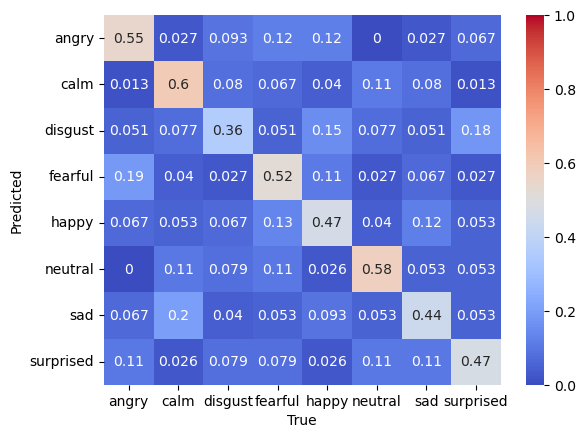

In [31]:
# codice che stampa la confusion matrix per il processo di classificazione
cf_KNN = confusion_matrix(y_test_KNN, y_pred_KNN, normalize='true')
sns.heatmap(cf_KNN, annot=True, cmap="coolwarm",  vmin=0, vmax=1 , yticklabels=np.unique(y_pred_KNN), xticklabels=np.unique(y_pred_KNN))
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [32]:
y_test_pred_proba_KNN = clf_KNN.predict_proba(X_test_KNN)

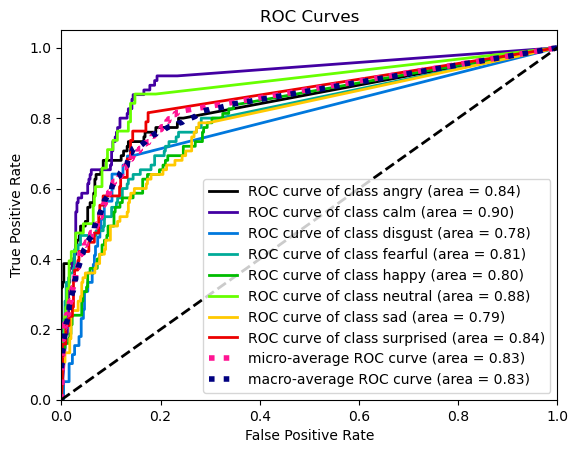

              precision    recall  f1-score   support

       angry       0.57      0.55      0.56        75
        calm       0.58      0.60      0.59        75
     disgust       0.33      0.36      0.34        39
     fearful       0.51      0.52      0.52        75
       happy       0.50      0.47      0.48        75
     neutral       0.48      0.58      0.52        38
         sad       0.52      0.44      0.48        75
   surprised       0.42      0.47      0.44        38

    accuracy                           0.50       490
   macro avg       0.49      0.50      0.49       490
weighted avg       0.51      0.50      0.50       490



In [33]:
# plot della curva ROC
ROC_KNN=plot_roc(y_test_KNN,y_test_pred_proba_KNN)
plt.show()
CR_KNN=classification_report(y_test_KNN, y_pred_KNN)
print(CR_KNN)

***

### **Random Forest**

In [34]:
# consideriamo anche le variabili categoriche

# escludiamo le colonne con una percentuale di outliers superiore alla soglia
soglia = 3
df_RF = rimoz_outliers(dummy_df_train.copy(), soglia)
X = df_RF.values

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y_em, test_size=0.2, stratify=y_em, random_state=0)
X_train_RF.shape,  X_test_RF.shape

((1956, 17), (490, 17))

In [35]:
# ricerca dei parametri ottimali
def objective_rf(trial):

    params = {
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 20, 30)
    }

    clf = RandomForestClassifier(**params, random_state=1)
    skf= RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(clf, X_train_RF, y_train_RF, cv=skf, scoring="accuracy")
    score = np.mean(scores)

    return score

In [36]:
# mettere a True se si riallena il modello, lasciare a False se si vuole caricare il modello già allenato
controllo = False

if controllo:
    study = optuna.create_study(sampler=TPESampler(), direction="maximize")
    study.optimize(objective_rf, n_trials=50, n_jobs=-1, timeout=2000)

    bests=study.best_params

    # allenamento del modello con gli iperparametri ottimali trovati da optuna
    rf = RandomForestClassifier(**bests, random_state=1)
    rf.fit(X_train_RF, y_train_RF)

    ## Salvataggio del modello su disco
    dump(rf, 'trained_model/rand_forest_model.joblib')

else:
    ## Caricamento del modello
    rf = load('trained_model/rand_forest_model.joblib')


***

<div style="background-color: #ffcccc; padding: 10px;">

**I migliori parametri del training sono:**

bests={'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'bootstrap': False,
 'n_estimators': 282,
 'max_depth': 21}

</div>

***

In [37]:
# calcolo dell'accuracy
y_pred_RF = rf.predict(X_test_RF)
accuracy_score(y_test_RF, y_pred_RF)

0.5530612244897959

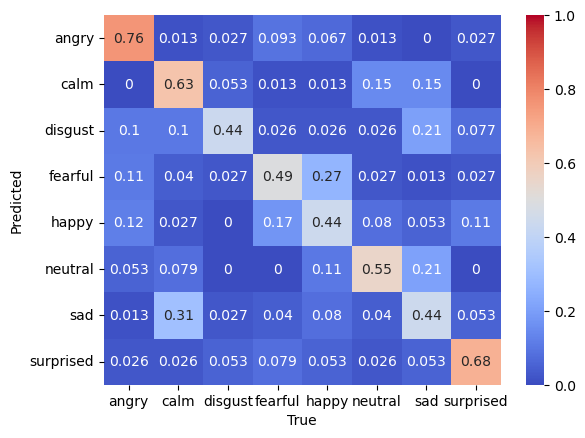

In [38]:
# codice che stampa la confusion matrix per il processo di classificazione
cf_RF = confusion_matrix(y_test_RF, y_pred_RF, normalize='true')
sns.heatmap(cf_RF, annot=True, cmap="coolwarm",  vmin=0, vmax=1, yticklabels=np.unique(y_pred_RF), xticklabels=np.unique(y_pred_RF))
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

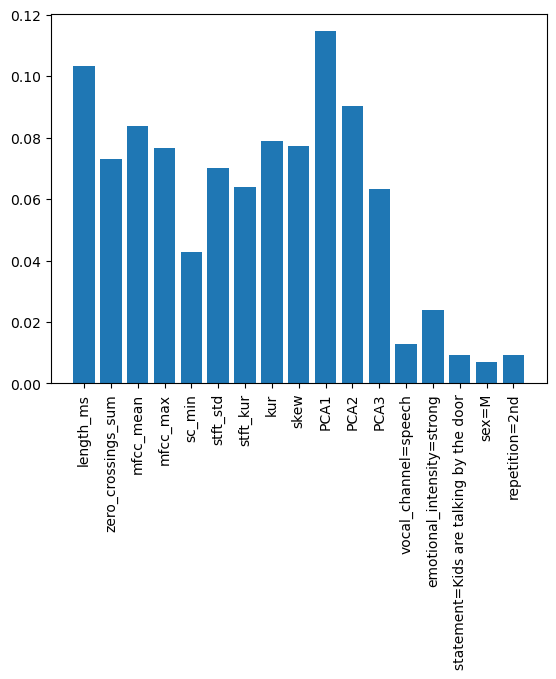

In [39]:
# visualizzazione dei parametri più significativi nel processo di classificazione
plt.bar(df_RF.columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [40]:
y_test_pred_proba_RF = rf.predict_proba(X_test_RF)

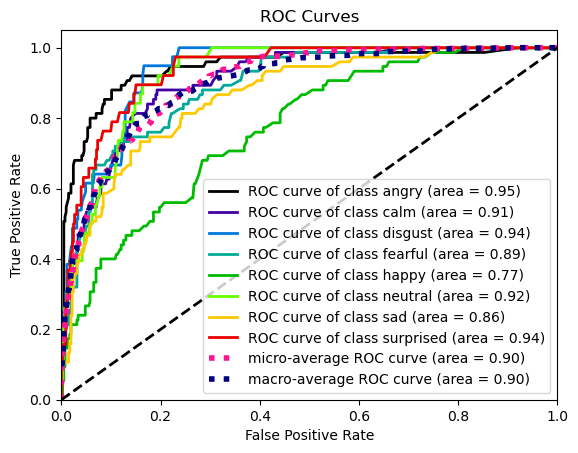

              precision    recall  f1-score   support

       angry       0.70      0.76      0.73        75
        calm       0.56      0.63      0.59        75
     disgust       0.59      0.44      0.50        39
     fearful       0.57      0.49      0.53        75
       happy       0.46      0.44      0.45        75
     neutral       0.46      0.55      0.50        38
         sad       0.49      0.44      0.46        75
   surprised       0.58      0.68      0.63        38

    accuracy                           0.55       490
   macro avg       0.55      0.55      0.55       490
weighted avg       0.55      0.55      0.55       490



In [41]:
# plot della curva di ROC
ROC_RF=plot_roc(y_test_RF,y_test_pred_proba_RF)
plt.show()
CR_RF=classification_report(y_test_RF, y_pred_RF)
print(CR_RF)


***

### **SVM**

In [42]:
# da  escludo le variabili categoriche escludo le colonne con un numero
df_SVM = dummy_df_train[dummy_df_train.select_dtypes(exclude='bool').columns].copy()

# di outliers pari a soglia includo gli outliers
soglia = 3
df_SVM = rimoz_outliers(df_SVM, soglia)
X = df_SVM.values

X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y_em, test_size=0.2, stratify=y_em, random_state=3)
X_train_SVM.shape, X_test_SVM.shape

((1956, 12), (490, 12))

In [43]:
def objective_SVM(trial):

    params = {
        "C": trial.suggest_float("C", 100.0, 1000.0),
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
        "coef0": trial.suggest_float("coef0", 0.0, 10.0),
        "gamma": trial.suggest_categorical("gamma", ['scale', 'auto']),
        "degree": trial.suggest_int("degree", 1, 6),
    }

    clf = SVC(**params, probability=True)
    skf= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(clf, X_train_SVM, y_train_SVM, cv=skf, scoring="accuracy")
    score = np.mean(scores)

    return score

In [44]:
# mettere a True se si riallena il modello, lasciare a False se si vuole caricare il modello già allenato
controllo = False

if controllo:
    study = optuna.create_study(sampler=TPESampler(), direction="maximize")
    study.optimize(objective_SVM, n_trials=10, n_jobs=-1, timeout=20000)

    bests= study.best_params

    # allenamento del modello con gli iperparametri ottimali trovati da optuna
    svm = SVC(**bests, probability=True)
    svm.fit(X_train_SVM, y_train_SVM)

    ## Salvataggio del modello su disco
    dump(svm, 'trained_model/svm_model.joblib')

else:
    ## Caricamento del modello
    svm = load('trained_model/svm_model.joblib')

***
<div style="background-color: #ffcccc; padding: 10px;">

**I migliori parametri del training sono:**

bests = {'C': 700.2783405106492, 'kernel': 'rbf', 'coef0': 9.992441379593126, 'gamma': 'auto', 'degree': 1}

</div>

***

In [45]:
# calcolo dell'accuracy
y_pred_SVM = svm.predict(X_test_SVM)
accuracy_score(y_test_SVM, y_pred_SVM)

0.5183673469387755

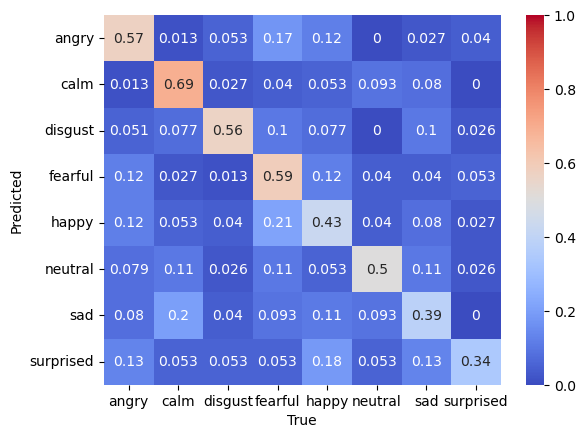

In [46]:
# codice che stampa la confusion matrix per il processo di classificazione
cf_SVM = confusion_matrix(y_test_SVM, y_pred_SVM, normalize='true')
sns.heatmap(cf_SVM, annot=True, cmap="coolwarm",  vmin=0, vmax=1 , yticklabels=np.unique(y_pred_SVM), xticklabels=np.unique(y_pred_SVM))
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [47]:
y_test_pred_proba_SVM = svm.predict_proba(X_test_SVM)

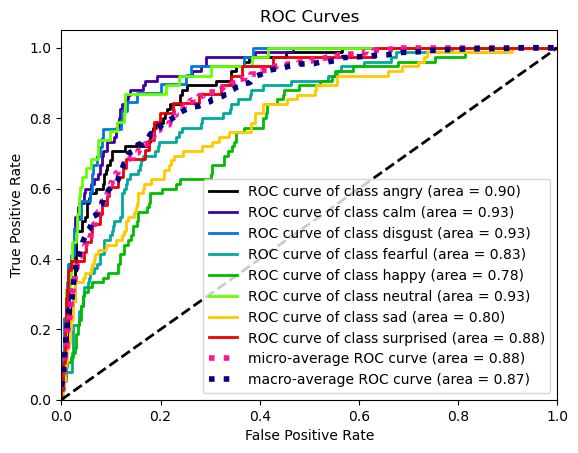

              precision    recall  f1-score   support

       angry       0.55      0.57      0.56        75
        calm       0.63      0.69      0.66        75
     disgust       0.58      0.56      0.57        39
     fearful       0.47      0.59      0.52        75
       happy       0.43      0.43      0.43        75
     neutral       0.46      0.50      0.48        38
         sad       0.49      0.39      0.43        75
   surprised       0.54      0.34      0.42        38

    accuracy                           0.52       490
   macro avg       0.52      0.51      0.51       490
weighted avg       0.52      0.52      0.51       490



In [48]:
# plot della curva di ROC
ROC_SVM=plot_roc(y_test_SVM,y_test_pred_proba_SVM)
plt.show()
CR_SVM =classification_report(y_test_SVM, y_pred_SVM)
print(CR_SVM)


***
***
***